In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from load_chebi import load_ontology, load_chebi
from matplotlib.patches import Ellipse
import xml.etree.ElementTree as ET
from tqdm import tqdm
from math import inf
import json

full_chebi_ontology = load_chebi()

ChEBI ontology already exists locally.
Loading ChEBI ontology...
Loaded ontology with 223956 classes and 3793010 axioms.


In [2]:
def find_paths_to_root(ontology, start_class):
    paths = []

    def dfs(current_class, current_path):
        superclasses = ontology.get_superclasses(current_class)
        superclasses = [s for s in superclasses if s not in current_path] # Remove circular references

        if not superclasses: # Reached root
            paths.append(current_path)
            return
        
        for superclass in superclasses:
            dfs(superclass, current_path + [superclass]) # Appends superclass to path

    dfs(start_class, [start_class])
    return paths

def find_paths_to_root_new(ontology, start_class, leaf_to_parents_json_file): # should work for leaf classes too
    paths = []

    # Unified DFS (works for both ontology and leaf parents)
    def dfs(current_class, current_path):
        superclasses = ontology.get_superclasses(current_class)
        superclasses = [s for s in superclasses if s not in current_path]

        if not superclasses:  # reached root
            paths.append(current_path)
            return

        for superclass in superclasses:
            dfs(superclass, current_path + [superclass])

    # -----------------------------------------
    # CASE 1: class is a leaf → load parent map
    # -----------------------------------------
    with open(leaf_to_parents_json_file, "r") as f:
        leaf_to_parents = json.load(f)

    if start_class in leaf_to_parents:

        direct_parents = leaf_to_parents[start_class]
        if not isinstance(direct_parents, list):
            direct_parents = [direct_parents]

        # Start DFS from each parent, but include the leaf in the initial path
        for parent in direct_parents:
            dfs(parent, [start_class, parent])

        return paths
    
    else:
    # -----------------------------------------
    # CASE 1: class exists in filtered ontology (is not a leaf)
    # -----------------------------------------
    
        dfs(start_class, [start_class])
        return paths



In [15]:
def get_name(chebi_ontology, iri):
    tree = ET.parse(chebi_ontology)
    root = tree.getroot()
    ns = {
        'owl': 'http://www.w3.org/2002/07/owl#',
        'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
        'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'
    }
    
    # Find all OWL classes
    for cls in root.findall('owl:Class', ns):
        about = cls.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about')
        if about == iri:
            # print(f"Found class for IRI: {iri}")
            # Find rdfs:label element
            label_elem = cls.find('rdfs:label', ns)
            if label_elem is not None:
                return label_elem.text.strip()

    return None  # if not found

def create_graph_from_paths(paths):
    G = nx.DiGraph()
    for path in paths:
        for i in range(len(path) - 1):
            G.add_edge(path[i], path[i + 1])
    
    # Remove prefix for better readability
    # mapping = {node: node.replace("http://purl.obolibrary.org/obo/CHEBI_", "") for node in G.nodes()}

    """uncomment to integrate ontology labels (slows down graph creation significantly)"""
    # chebi_ontology="data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl"
    # mapping = {}
    # for node in G.nodes():
    #     label = get_name(chebi_ontology, node) #integrate the ontology better
    #     if label:
    #         mapping[node] = label
    #     else:
    #         # mapping[node] = node
    #         mapping[node] = node.replace("http://purl.obolibrary.org/obo/CHEBI_", "")
    # G = nx.relabel_nodes(G, mapping)
    
    return G
    

In [8]:
# Glucose - rdf:about="http://purl.obolibrary.org/obo/CHEBI_17234"

# Find all paths from glucose to root in ontology
ontology_file = "data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl"
ontology = load_ontology(ontology_file)

glucose_id = "http://purl.obolibrary.org/obo/CHEBI_17234"

# Find all paths from glucose to root in ontology
paths = find_paths_to_root(ontology, glucose_id)
print(f"Paths from glucose to root:")
for path in paths:
    print(" -> ".join(path))

Loading ontology...
Loaded ontology from data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl with 14942 classes and 225573 axioms.
Paths from glucose to root:
http://purl.obolibrary.org/obo/CHEBI_17234 -> http://purl.obolibrary.org/obo/CHEBI_33917 -> http://purl.obolibrary.org/obo/CHEBI_15693 -> http://purl.obolibrary.org/obo/CHEBI_35381 -> http://purl.obolibrary.org/obo/CHEBI_16646 -> http://purl.obolibrary.org/obo/CHEBI_78616 -> http://purl.obolibrary.org/obo/CHEBI_36963 -> http://purl.obolibrary.org/obo/CHEBI_25806 -> http://purl.obolibrary.org/obo/CHEBI_33304 -> http://purl.obolibrary.org/obo/CHEBI_33675 -> http://purl.obolibrary.org/obo/CHEBI_33579 -> http://purl.obolibrary.org/obo/CHEBI_23367 -> http://purl.obolibrary.org/obo/CHEBI_24431
http://purl.obolibrary.org/obo/CHEBI_17234 -> http://purl.obolibrary.org/obo/CHEBI_33917 -> http://purl.obolibrary.org/obo/CHEBI_15693 -> http://purl.obolibrary.org/obo/CHEBI_35381 -> http://purl.obolibrary.org/obo/CHEBI_16646 

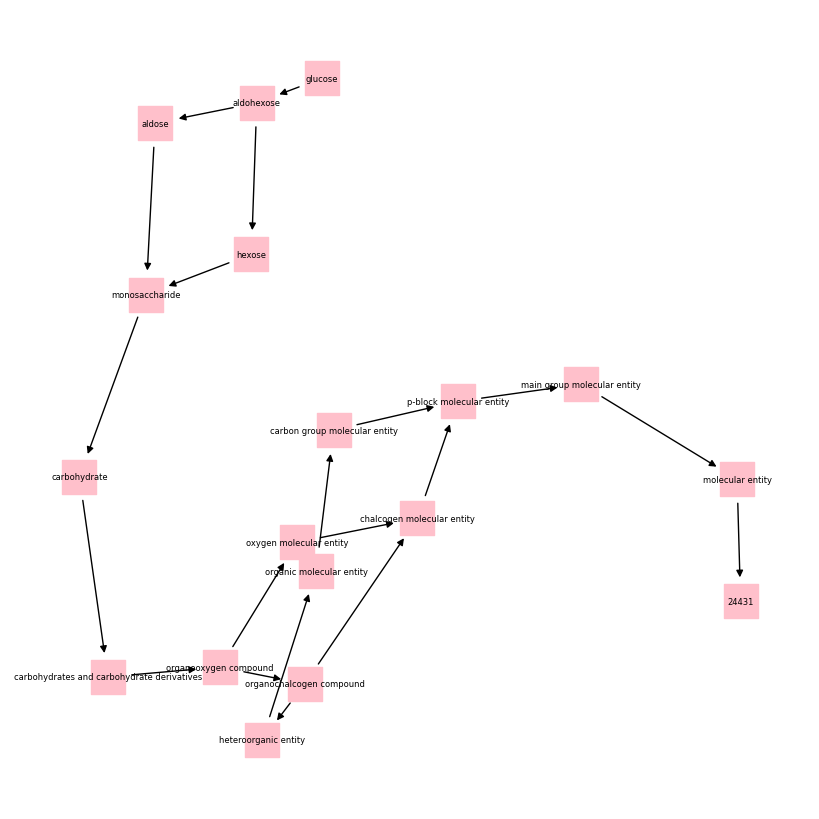

In [9]:
glucose_graph = create_graph_from_paths(paths)
plt.figure(figsize=(8, 8))
nx.draw(glucose_graph, with_labels=True, node_size=600, node_shape='s', font_size=6, node_color='pink')

In [4]:
# Find n leaf classes in ontology and get their IRIs
def get_n_leaf_classes(ontology, n):
    classes = []
    all_classes = ontology.get_classes()
    for cls in all_classes:
        # Check if class is a leaf (no subclasses)
        if len(ontology.get_subclasses(cls)) == 0:
            classes.append(cls)
        if len(classes) >= n:
            break
    return classes

def filter_classes(classes, max_paths, max_total_nodes):
    classes_to_use = []
    for i, cls in enumerate(classes):
        print(f"Leaf class IRI: {cls}")
        paths = find_paths_to_root_new(ontology, cls, leaf_to_parents_json_file = "data/removed_leaf_classes_to_direct_parents_map.json")
        if len(paths) > max_paths:
            print(f"Skipping class {cls} with {len(paths)} paths to root (too many to display).")
            continue
        # if number of nodes in all paths is too high, skip
        total_nodes = sum(len(path) for path in paths)
        if total_nodes > max_total_nodes:
            print(f"Skipping class {cls} with total nodes {total_nodes} in paths to root (too many to display).")
            continue
        classes_to_use.append(cls)
    return classes_to_use
    
def create_graph(classes, color_map, max_n_leaf_classes=inf):
    G = nx.DiGraph()
    j = 0
    for i, cls in enumerate(classes):
        print(f"Adding to graph... Starting node: {cls}")
        paths = find_paths_to_root_new(ontology, cls, leaf_to_parents_json_file = "data/removed_leaf_classes_to_direct_parents_map.json")
        H = create_graph_from_paths(paths)
        # Color the nodes of H 
        color = color_map[j % len(color_map)]
        nx.set_node_attributes(H, color, 'color')

        G = nx.compose(G, H)  # Combine graphs
        j += 1    
        if j >= max_n_leaf_classes:
            break

        print(f"Total number of starting leaf classes processed in graph: {j}")
    return G

def draw_graph(G, graphing_layout, title):
    if graphing_layout == "default":
        pos = None  # Default layout
    elif graphing_layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif graphing_layout == "spectral":
        pos = nx.spectral_layout(G)
    elif graphing_layout == "layer_based":
        # Calculate depth of each node from root
        roots = [n for n, d in G.in_degree() if d == 0]
        if roots:
            # Assign layer based on shortest path from root
            layers = {}
            for node in G.nodes():
                min_dist = float('inf')
                for root in roots:
                    if nx.has_path(G, root, node):
                        dist = nx.shortest_path_length(G, root, node)
                        min_dist = min(min_dist, dist)
                layers[node] = min_dist if min_dist != float('inf') else 0
            
            # Set subset attribute for multipartite layout
            nx.set_node_attributes(G, layers, 'subset')
            pos = nx.multipartite_layout(G, subset_key='subset', align='horizontal')
    else:
        print(f"Unknown graphing layout: {graphing_layout}. Using default.")
        pos = None  # Default layout


    plt.figure(figsize=(20, 10))

    # Draw nodes with their assigned colors
    node_colors = [G.nodes[n].get("color") for n in G.nodes()]

    nx.draw(G, pos, with_labels=True, node_size=500, node_shape='s', font_size=8, font_weight='bold', node_color=node_colors, arrows=True,
            arrowsize=12, edge_color='black', alpha=1)

    plt.title(title, fontsize=12)
    plt.show()

Loading ontology...
Loaded ontology from data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl with 14942 classes and 225573 axioms.
Adding to graph... Starting node: http://purl.obolibrary.org/obo/CHEBI_17234
Total number of starting leaf classes processed in graph: 1


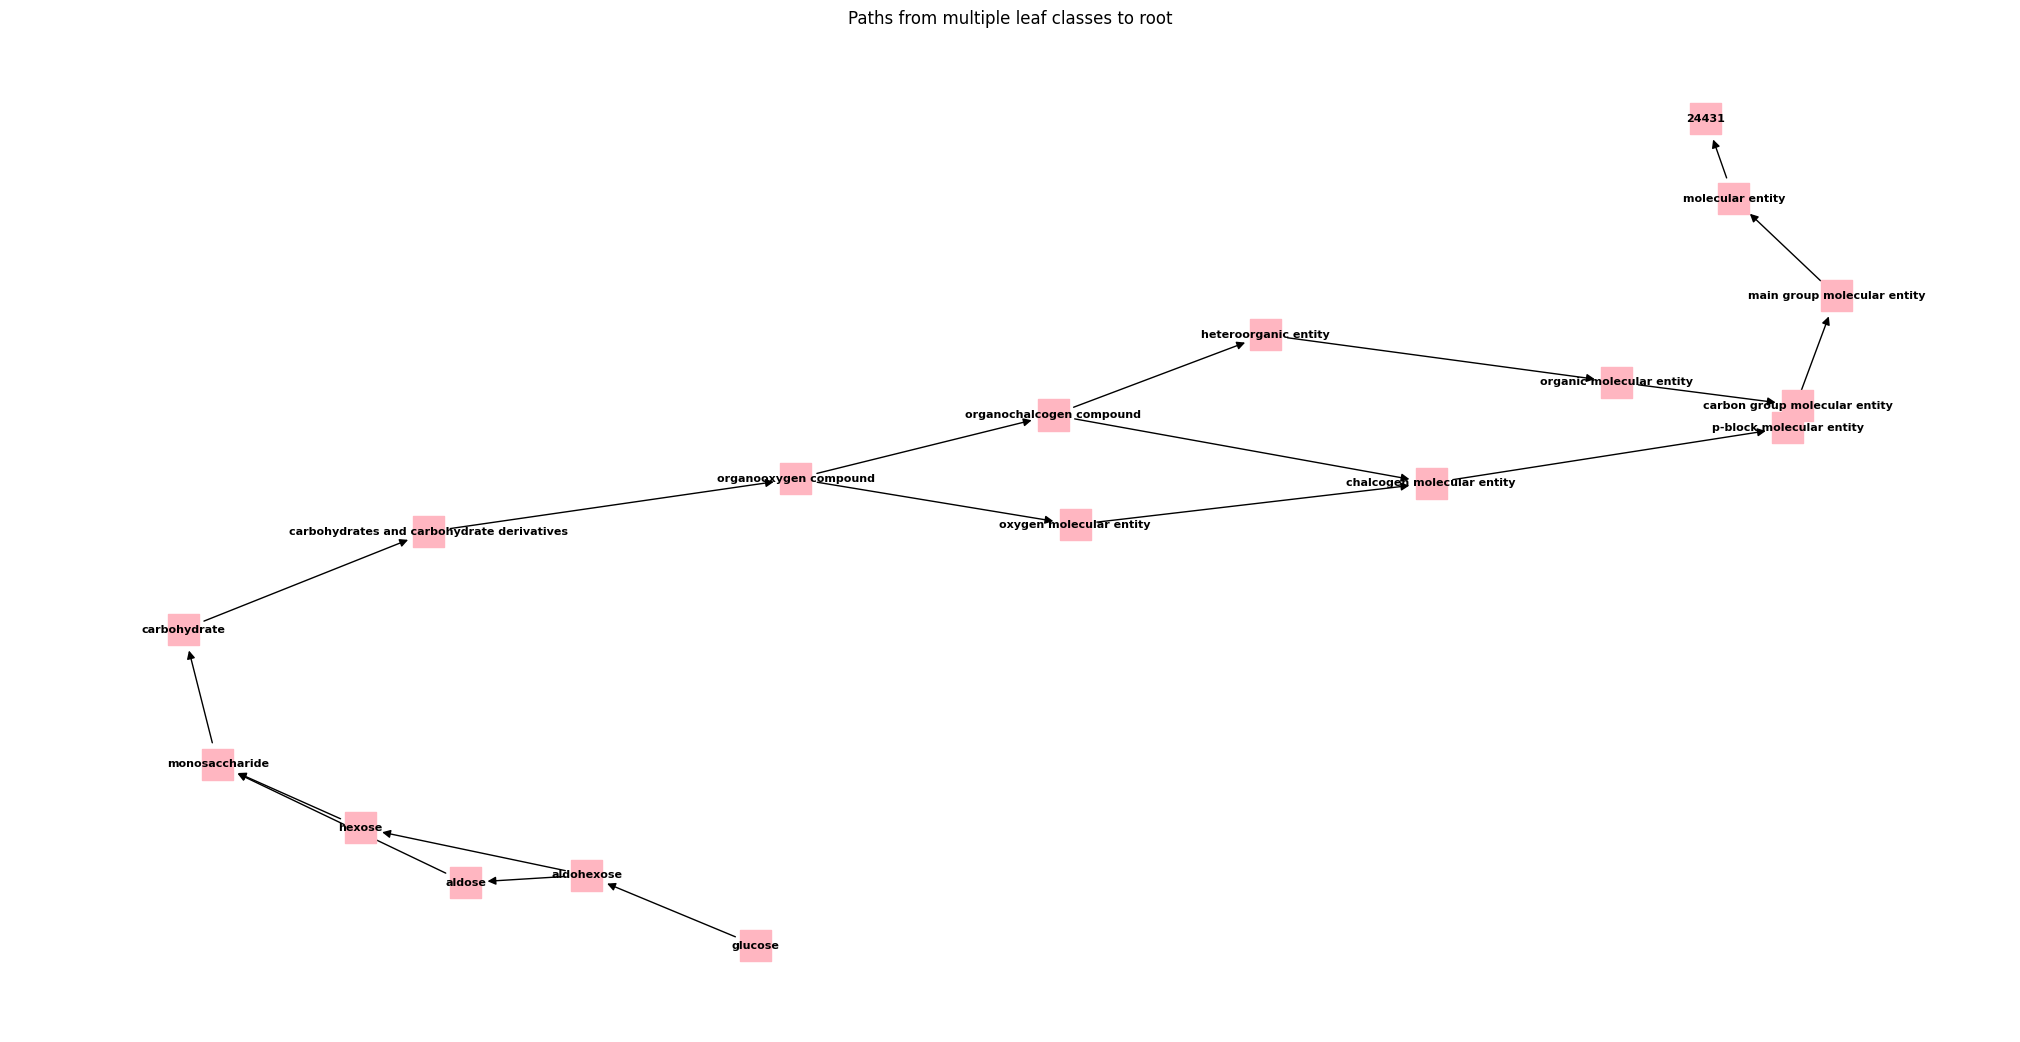

In [10]:
# --- Usage ---
ontology_file = "data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl"
ontology = load_ontology(ontology_file)

graphing_layout = "default"  # options: "default", "kamada_kawai", "spectral", "layer_based"
n = 10
max_n_leaf_classes = inf
color_map = ['#FFB6C1', "#F44280", "#AA83A7", "#83163A", "#E63FE6", '#FFA07A', '#FF69B4']
title = "Paths from multiple leaf classes to root"

#classes = get_n_leaf_classes(ontology, n)
#classes = filter_classes(classes, max_paths=15, max_total_nodes=50)
#classes = ["http://purl.obolibrary.org/obo/CHEBI_15377"]
# classes = ["http://purl.obolibrary.org/obo/CHEBI_17234", "http://purl.obolibrary.org/obo/CHEBI_15377"]
# classes = ["http://purl.obolibrary.org/obo/CHEBI_35352"] 
# classes = ["http://purl.obolibrary.org/obo/CHEBI_77030"]
# classes = ["http://purl.obolibrary.org/obo/CHEBI_35352", "http://purl.obolibrary.org/obo/CHEBI_17234"] 
classes = ["http://purl.obolibrary.org/obo/CHEBI_17234"]

G = create_graph(classes, color_map, max_n_leaf_classes)
draw_graph(G, graphing_layout, title)

Adding to graph... Starting node: http://purl.obolibrary.org/obo/CHEBI_37626
Total number of starting leaf classes processed in graph: 1


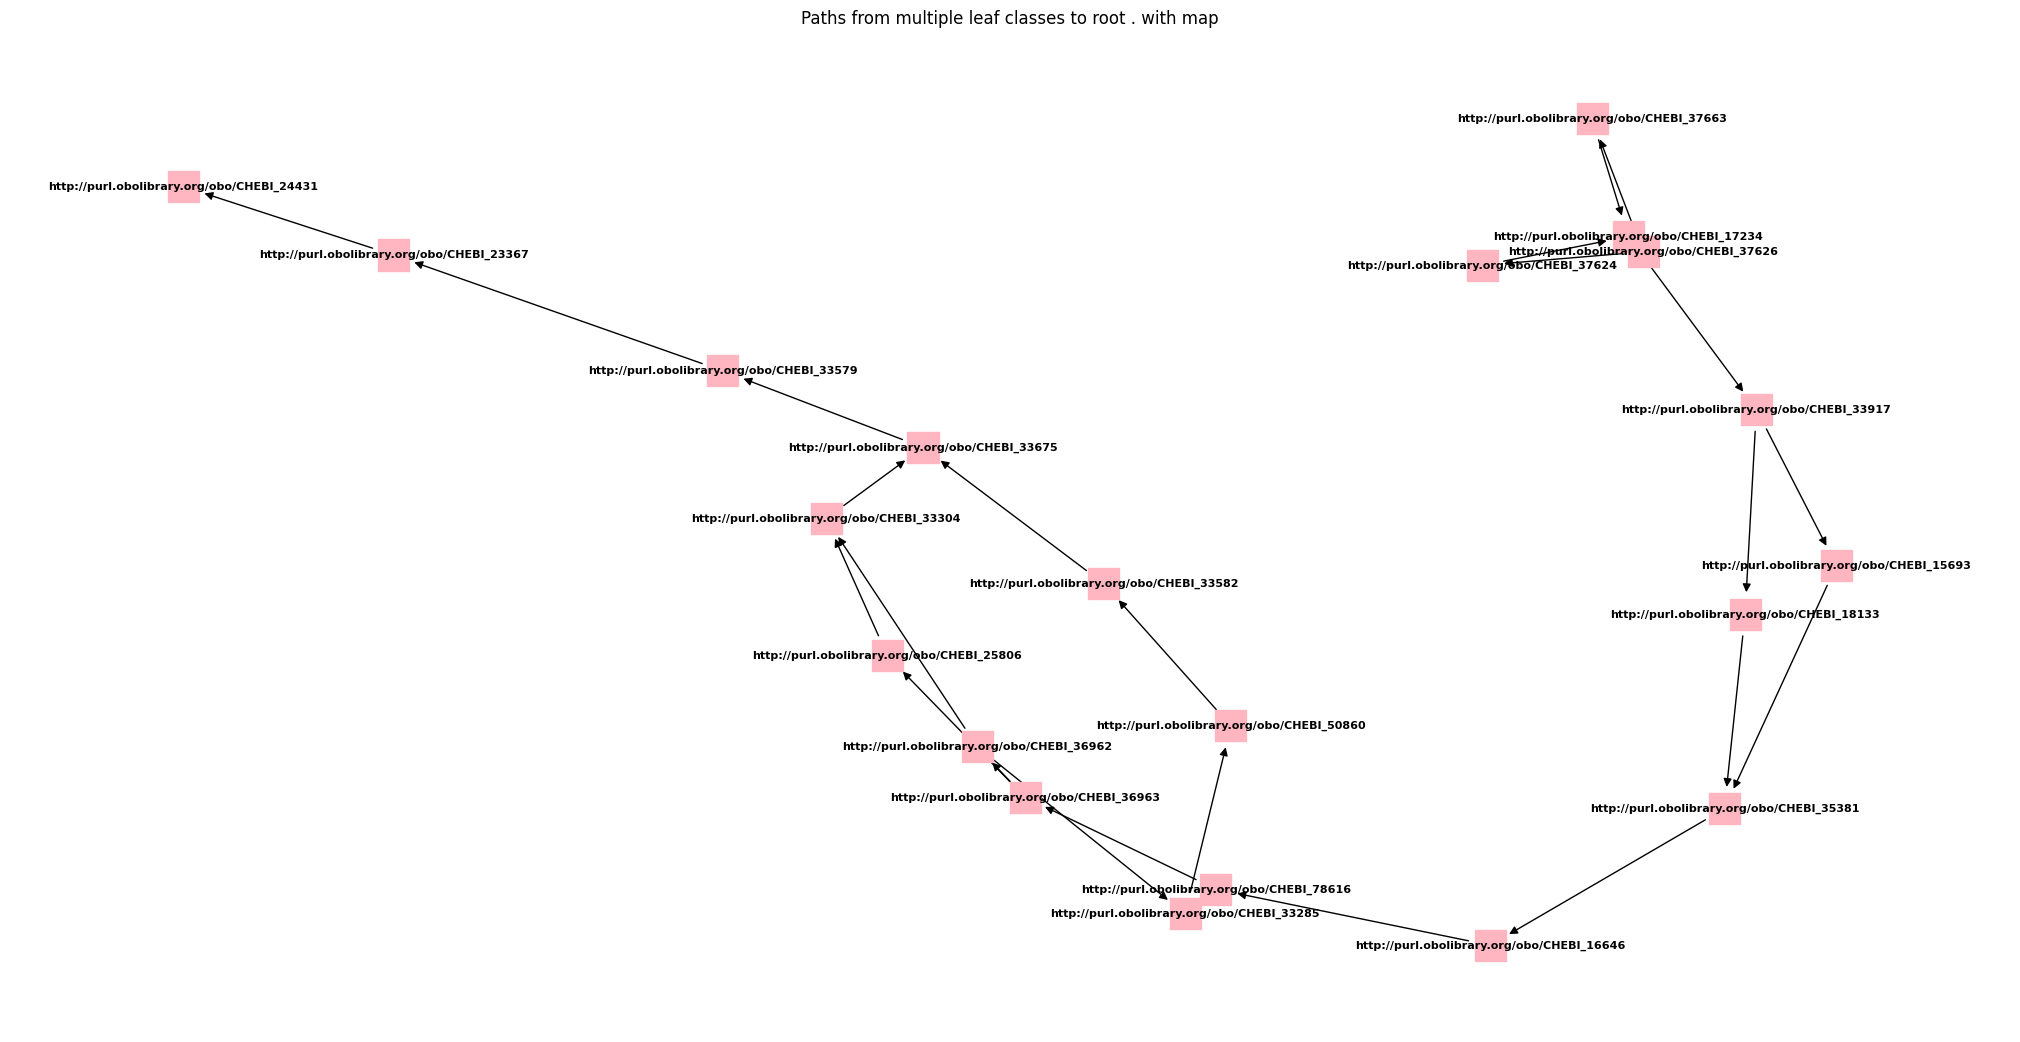

In [18]:
def find_paths_to_root_with_map(parent_map_json_file, start_class):
    paths = []

    with open(parent_map_json_file, "r") as f:
        parents_map = json.load(f)

    def dfs(current_class, current_path):
        # if the class has no parents in the map, it's a root
        parents = parents_map.get(current_class, [])
        if not parents:
            paths.append(current_path)
            return
        
        for parent in parents:
            dfs(parent, current_path + [parent])

    dfs(start_class, [start_class])
    return paths
            

def create_graph_from_map(classes, parent_map_json_file, color_map = ['#FFB6C1', "#F44280", "#AA83A7", "#83163A", "#E63FE6", '#FFA07A', '#FF69B4'], max_n_leaf_classes=inf):
    G = nx.DiGraph()
    j = 0

    for i, cls in enumerate(classes):
        print(f"Adding to graph... Starting node: {cls}")
        paths = find_paths_to_root_with_map(parent_map_json_file, cls)
        H = create_graph_from_paths(paths)
        # Color the nodes of H 
        color = color_map[j % len(color_map)]
        nx.set_node_attributes(H, color, 'color')

        G = nx.compose(G, H)  # Combine graphs
        j += 1    
        if j >= max_n_leaf_classes:
            break

        print(f"Total number of starting leaf classes processed in graph: {j}")
    return G

graphing_layout = "default"  # options: "default", "kamada_kawai", "spectral", "layer_based"
max_n_leaf_classes = inf
color_map = ['#FFB6C1', "#F44280", "#AA83A7", "#83163A", "#E63FE6", '#FFA07A', '#FF69B4']
title = "Paths from multiple leaf classes to root . with map"

# classes = ["http://purl.obolibrary.org/obo/CHEBI_17234"]
classes = ["http://purl.obolibrary.org/obo/CHEBI_37626"]

mappygraphy = create_graph_from_map(classes, "data/chebi_parent_map.json", color_map, max_n_leaf_classes)
draw_graph(mappygraphy, graphing_layout, title)

**Pruning**

Pruning strategies in original BiNChE: https://github.com/pcm32/BiNCheWeb/wiki/BiNChE#graph-pruning-strategies

RootChildrenPruner: "https://github.com/pcm32/BiNChE/blob/develop/src/main/java/net/sourceforge/metware/binche/graph/RootChildrenPruner.java"

 * This pruner aims to delete the roots (the more general entities in the ontology) and its children up to a defined level.
 * Removes the defined level of children from the root class of the ontology.

Removed nodes by root children pruner: {'24431', 'molecular entity'}


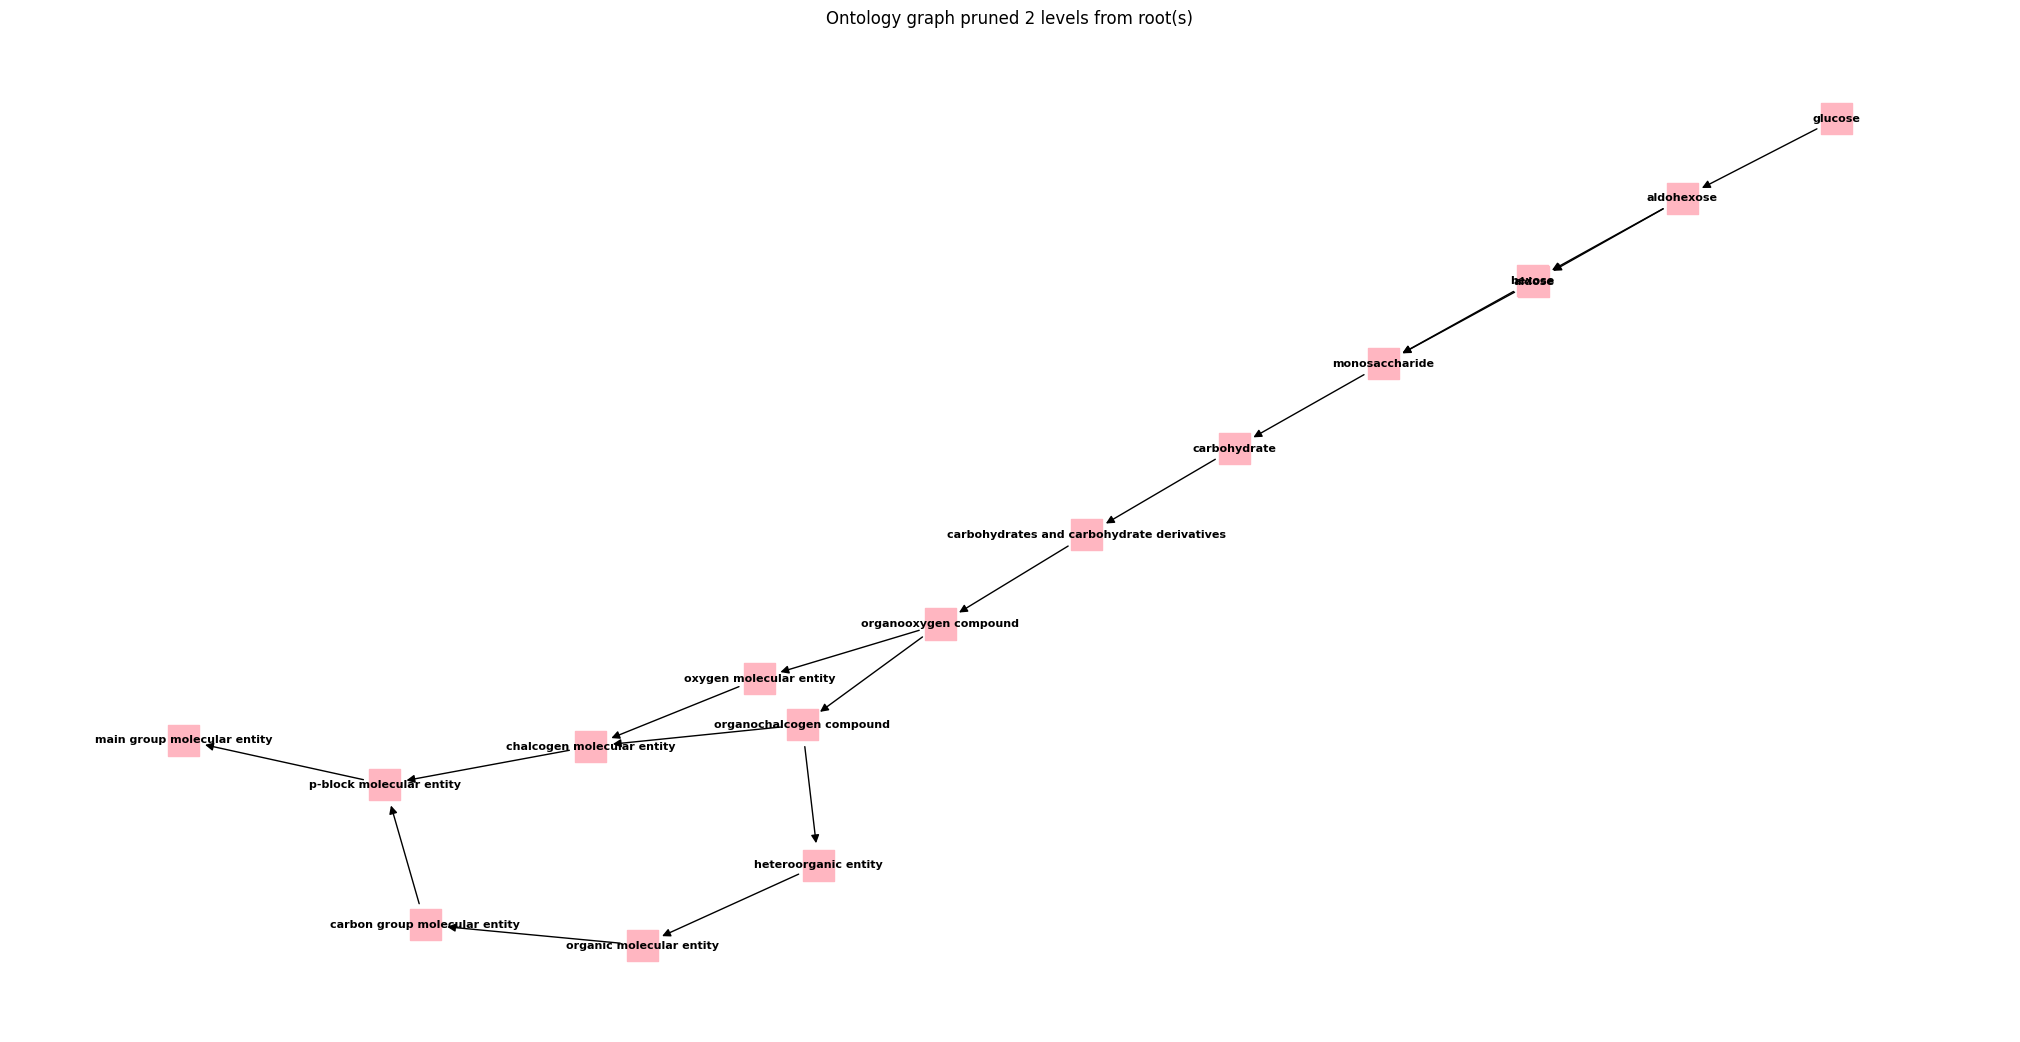

In [32]:
""" RootChildrenPruner:
This pruner aims to delete the roots (the more general entities in the ontology) and its children up to a defined level.
Removes the defined level of children from the root class of the ontology."""

# def delete_children(node, G, next_level):
#     if next_level > 0:
#         next_level -= 1
#         children = list(G.predecessors(node)) # In DiGraph, predecessors are children in this case
#         for child in children:
#             delete_children(child, G, next_level)
#         G.remove_node(node) 

# def root_children_pruner(G, levels, allow_re_execution, execution_count):
#     if allow_re_execution or execution_count == 0:
#         roots = [n for n, d in G.out_degree() if d == 0]
#         for root in roots:
#             delete_children(root, G, levels)
#         execution_count += 1
#     return G, execution_count

# def delete_children(node, G, next_level, removed_nodes):
    
#     # Record node before deletion
#     removed_nodes.append(node)

#     # Traverse down to the specified level and remove nodes
#     if next_level > 0:
#         next_level -= 1
#         children = list(G.predecessors(node)) # In DiGraph, predecessors are children in this case
#         for child in children:
#             delete_children(child, G, next_level, removed_nodes)
#         G.remove_node(node) 

# def root_children_pruner(G, levels, allow_re_execution = False, execution_count = 0):
#     removed_nodes = []
#     if allow_re_execution or execution_count == 0:
#         roots = [n for n, d in G.out_degree() if d == 0]
#         for root in roots:
#             delete_children(root, G, levels, removed_nodes)
#         execution_count += 1
#     return G, removed_nodes, execution_count

"""ta bort igen sen"""
def delete_children(node, G, next_level, removed_nodes):

    # Traverse down to the specified level and remove nodes
    if next_level > 0:
        next_level -= 1
        children = list(G.predecessors(node)) # In DiGraph, predecessors are children in this case
        for child in children:
            delete_children(child, G, next_level, removed_nodes)

        # Record note removal    
        G.remove_node(node) 
        removed_nodes.add(node)

def root_children_pruner(G, levels, allow_re_execution = False, execution_count = 0):
    removed_nodes = set()
    if allow_re_execution or execution_count == 0:
        roots = [n for n, d in G.out_degree() if d == 0]
        for root in roots:
            delete_children(root, G, levels, removed_nodes)
        execution_count += 1
    return G, removed_nodes, execution_count


"""Hit"""

# ---- Usage ----
# Variables
levels = 2 # Number of levels to prune from root. 1 only prunes root and it's direct neighbour, and so on.
allow_re_execution = True  # True or False. whether the pruner can be executed multiple times on a given graph.
execution_count = 0  # Counter for the number of executions

# OBS: first run cell to create G, then run the pruner function below. 
pruned_G = G.copy()
pruned_G, removed_nodes,execution_count = root_children_pruner(pruned_G, levels, allow_re_execution, execution_count)
print(f"Removed nodes by root children pruner: {removed_nodes}")

graphing_layout = "kamada_kawai" # options: "default", "kamada_kawai", "spectral", "layer_based"
draw_graph(pruned_G, graphing_layout, f"Ontology graph pruned {levels} levels from root(s)")





In [33]:
# Pruning graphymappy
pruned_graphy_mappy = mappygraphy.copy()
pruned_graphy_mappy, removed_nodes,execution_count = root_children_pruner(pruned_graphy_mappy, levels, allow_re_execution, execution_count)
print(f"Removed nodes by root children pruner: {removed_nodes}")

Removed nodes by root children pruner: {'http://purl.obolibrary.org/obo/CHEBI_24431', 'http://purl.obolibrary.org/obo/CHEBI_23367'}


Linear Branch Collapser Pruner 

In [6]:
""" Original linear_branch_collapser_pruner:
This pruner collapses linear branches in the ontology graph by removing all intermediate nodes in branches 
where each node has exactly one child, effectively connecting the start and end nodes of such branches directly.
"""
# def linear_branch_collapser_pruner(G):
#     roots = [n for n, d in G.out_degree() if d == 0]
#     for root in roots:
#         print(f"Processing root: {root}")
#         direct_children = list(G.predecessors(root))
#         print(f"Direct children of root {root}: {direct_children}")
#         for child in direct_children:
#             process_branch(root, child, G)
#     return G

# def process_branch(head, node, G):

#     branch_nodes = []
#     current_node = node

#     children = list(G.predecessors(current_node))

#     while len(children) == 1:
#         branch_nodes.append(current_node)
#         current_node = children[0]
#         children = list(G.predecessors(current_node))
#         print(f"Current node: {current_node}, Children: {children}")

#     last_node = current_node

#     if len(branch_nodes):
#         # Remove all nodes in the branch except the last node
#         for node in branch_nodes:
#             G.remove_node(node)
#         G.add_edge(last_node, head)

#     # Get children of the last node and repeat the process
#     children = list(G.predecessors(last_node))
#     for child in children:
#         process_branch(last_node, child, G)

#     return G

"""Linear branch collapser pruner - remove fewer nodes:
This pruner collapses linear branches in the ontology graph by removing fewer intermediate nodes in branches 
where each node has exactly one child, effectively connecting every n:th node in such branches directly.
Keeps every n:th node in linear branches."""
# Removing fewer nodes in linear branches


#### OBS: May have bugs - check python file visualitations_and_pruning.py

def process_branch_remove_less(head, node, G, n):

    branch_nodes = []
    current_node = node

    children = list(G.predecessors(current_node))

    while len(children) == 1:
        branch_nodes.append(current_node)
        current_node = children[0]
        children = list(G.predecessors(current_node))
        print(f"Current node: {current_node}, Children: {children}")

    last_node = current_node
    # Capture children BEFORE modifying the graph
    children_before = list(G.predecessors(last_node))   

    if len(branch_nodes):
        # Keep every n:th node in the branch
        i = 0
        nodes_to_keep = [head]
        
        for node in branch_nodes:
            i += 1
            if i % n == 0:
                nodes_to_keep.append(node)

        nodes_to_keep.append(last_node)
        print(f"Nodes to keep in branch: {nodes_to_keep}")

        for node in branch_nodes:
            if node not in nodes_to_keep:
                G.remove_node(node)

        for i in range(len(nodes_to_keep)-1):
            if not G.has_edge(nodes_to_keep[i+1], nodes_to_keep[i]):
                G.add_edge(nodes_to_keep[i+1], nodes_to_keep[i])

                print(f"Node {nodes_to_keep[i+1]} connected to {nodes_to_keep[i]}")


    # Recurse only over the original children (before graph modification)
    for child in children_before:                       
        process_branch_remove_less(last_node, child, G, n)


    return G


def linear_branch_collapser_pruner_remove_less(G, n):
    roots = [n for n, d in G.out_degree() if d == 0]
    for root in roots:
        print(f"Processing root: {root}")
        direct_children = list(G.predecessors(root))
        print(f"Direct children of root {root}: {direct_children}")
        for child in direct_children:
            process_branch_remove_less(root, child, G, n)
    return G
    


Processing root: 24431
Direct children of root 24431: ['molecular entity']
Current node: main group molecular entity, Children: ['p-block molecular entity']
Current node: p-block molecular entity, Children: ['chalcogen molecular entity', 'carbon group molecular entity']
Nodes to keep in branch: ['24431', 'main group molecular entity', 'p-block molecular entity']
Node main group molecular entity connected to 24431
Current node: organooxygen compound, Children: ['carbohydrates and carbohydrate derivatives']
Current node: carbohydrates and carbohydrate derivatives, Children: ['carbohydrate']
Current node: carbohydrate, Children: ['monosaccharide']
Current node: monosaccharide, Children: ['aldose', 'hexose']
Nodes to keep in branch: ['chalcogen molecular entity', 'organooxygen compound', 'carbohydrate', 'monosaccharide']
Node organooxygen compound connected to chalcogen molecular entity
Node carbohydrate connected to organooxygen compound
Current node: aldohexose, Children: ['glucose']
Cur

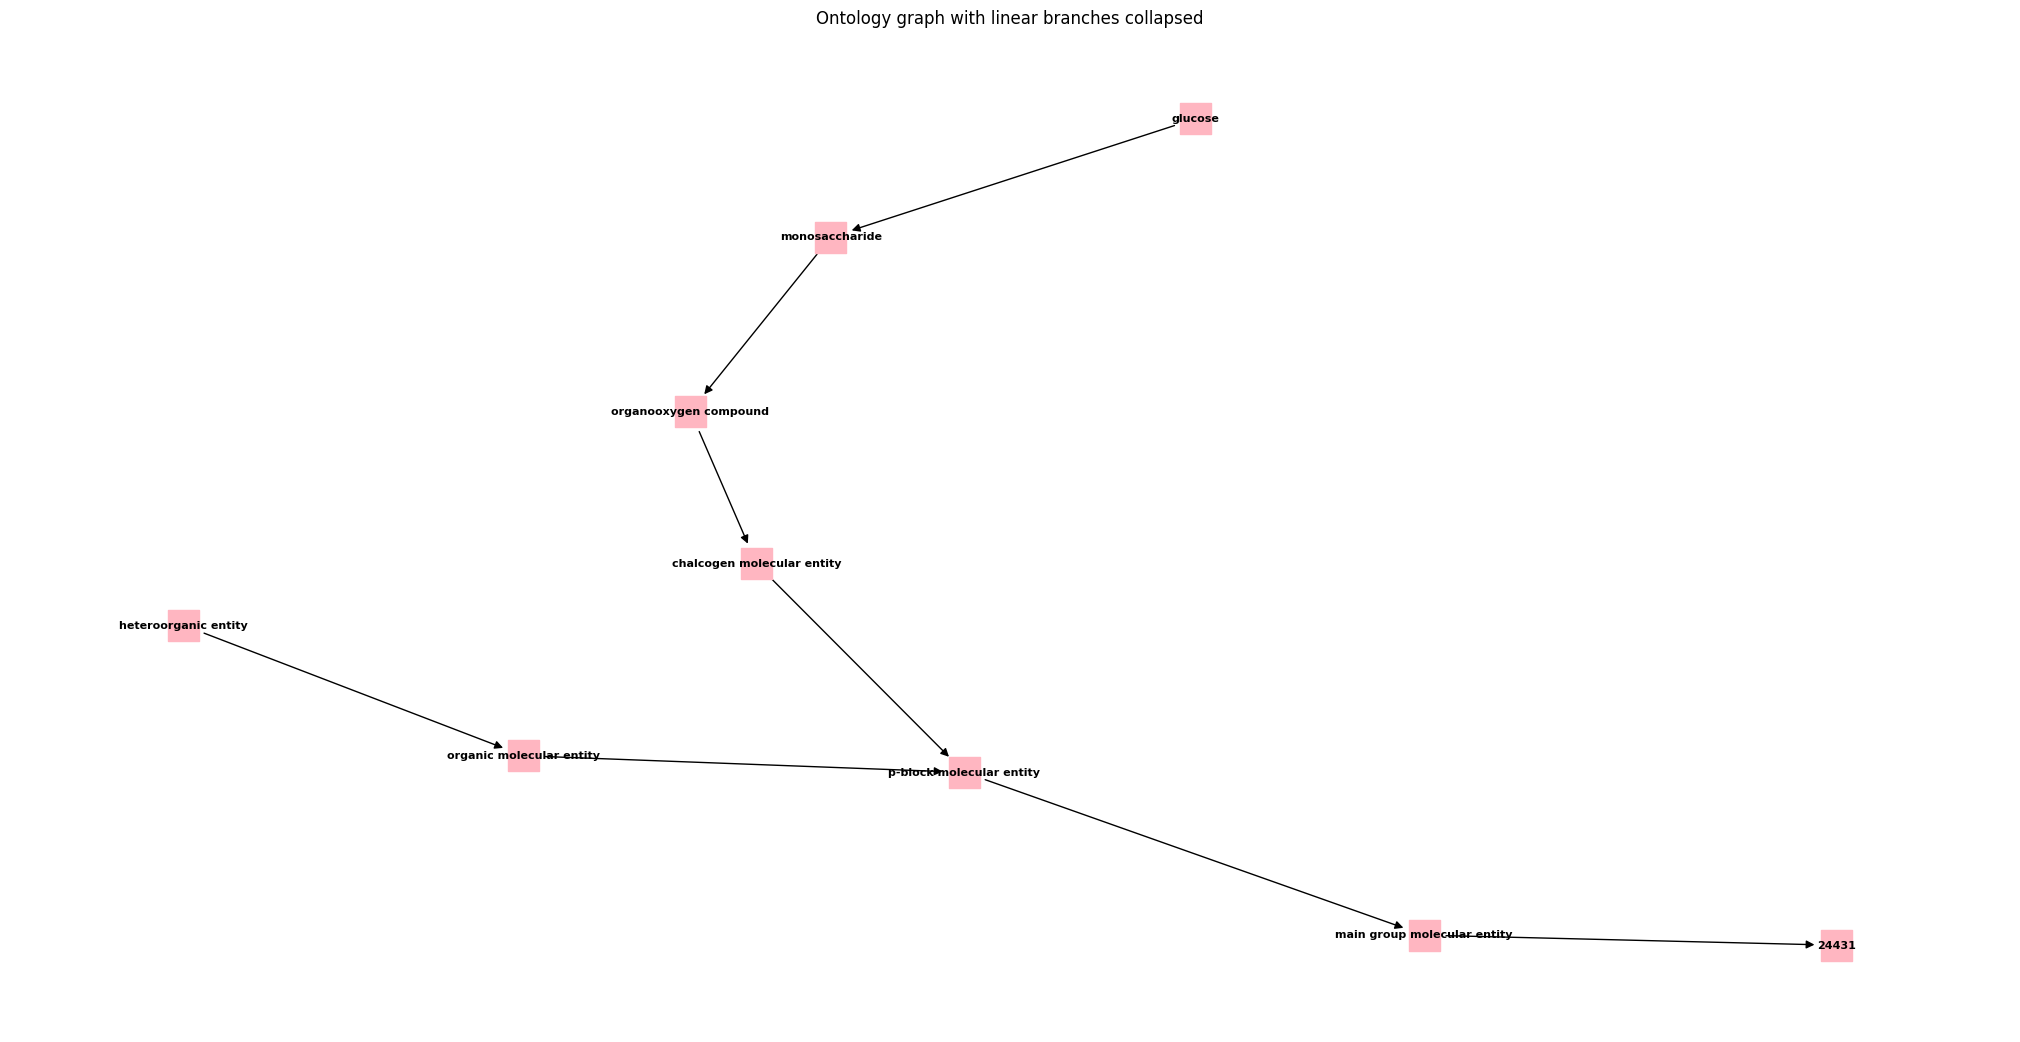

In [ ]:
pruned_G2 = pruned_G.copy()
pruned_G2 = linear_branch_collapser_pruner_remove_less(pruned_G2, 2)
draw_graph(pruned_G2, graphing_layout, f"Ontology graph pruned {levels} levels from root(s) and linear branches collapsed")

### Used straight after creating G
# pruned_G= G.copy()
# pruned_G = linear_branch_collapser_pruner_remove_less(pruned_G, 2)
# draw_graph(pruned_G, graphing_layout, f"Ontology graph with linear branches collapsed")

Processing root: main group molecular entity
Direct children of root main group molecular entity: ['p-block molecular entity', 'hydrogen molecular entity']
Current node: organonitrogen compound, Children: ['L-alanine derivative', 'alpha-amino acid', 'isoxazoles']
Current node: 77030, Children: []
Current node: 77030, Children: []
Processing root: polyatomic entity
Direct children of root polyatomic entity: ['molecule', 'heteroatomic molecular entity']


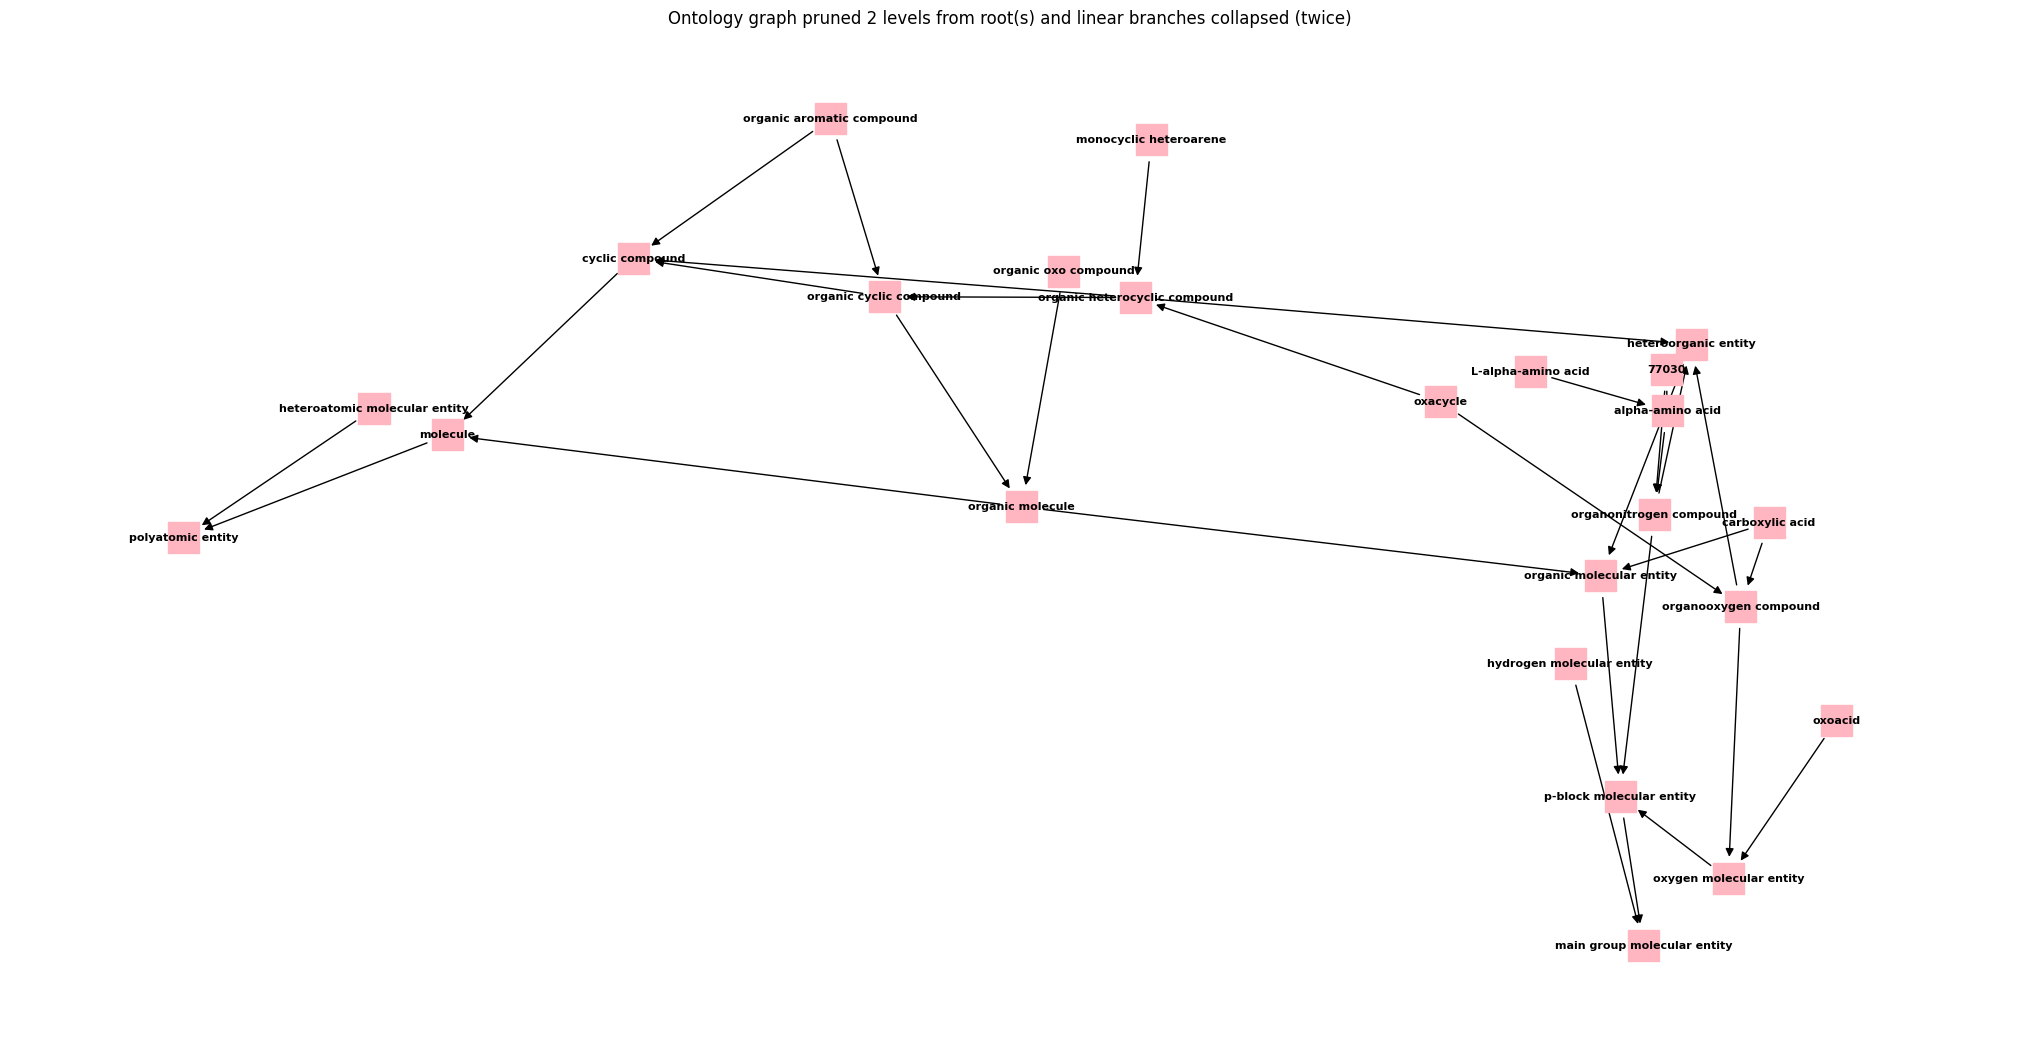

In [15]:
pruned_G3 = pruned_G2.copy()
pruned_G3 = linear_branch_collapser_pruner(pruned_G3)
draw_graph(pruned_G3, graphing_layout, f"Ontology graph pruned {levels} levels from root(s) and linear branches collapsed (twice)")


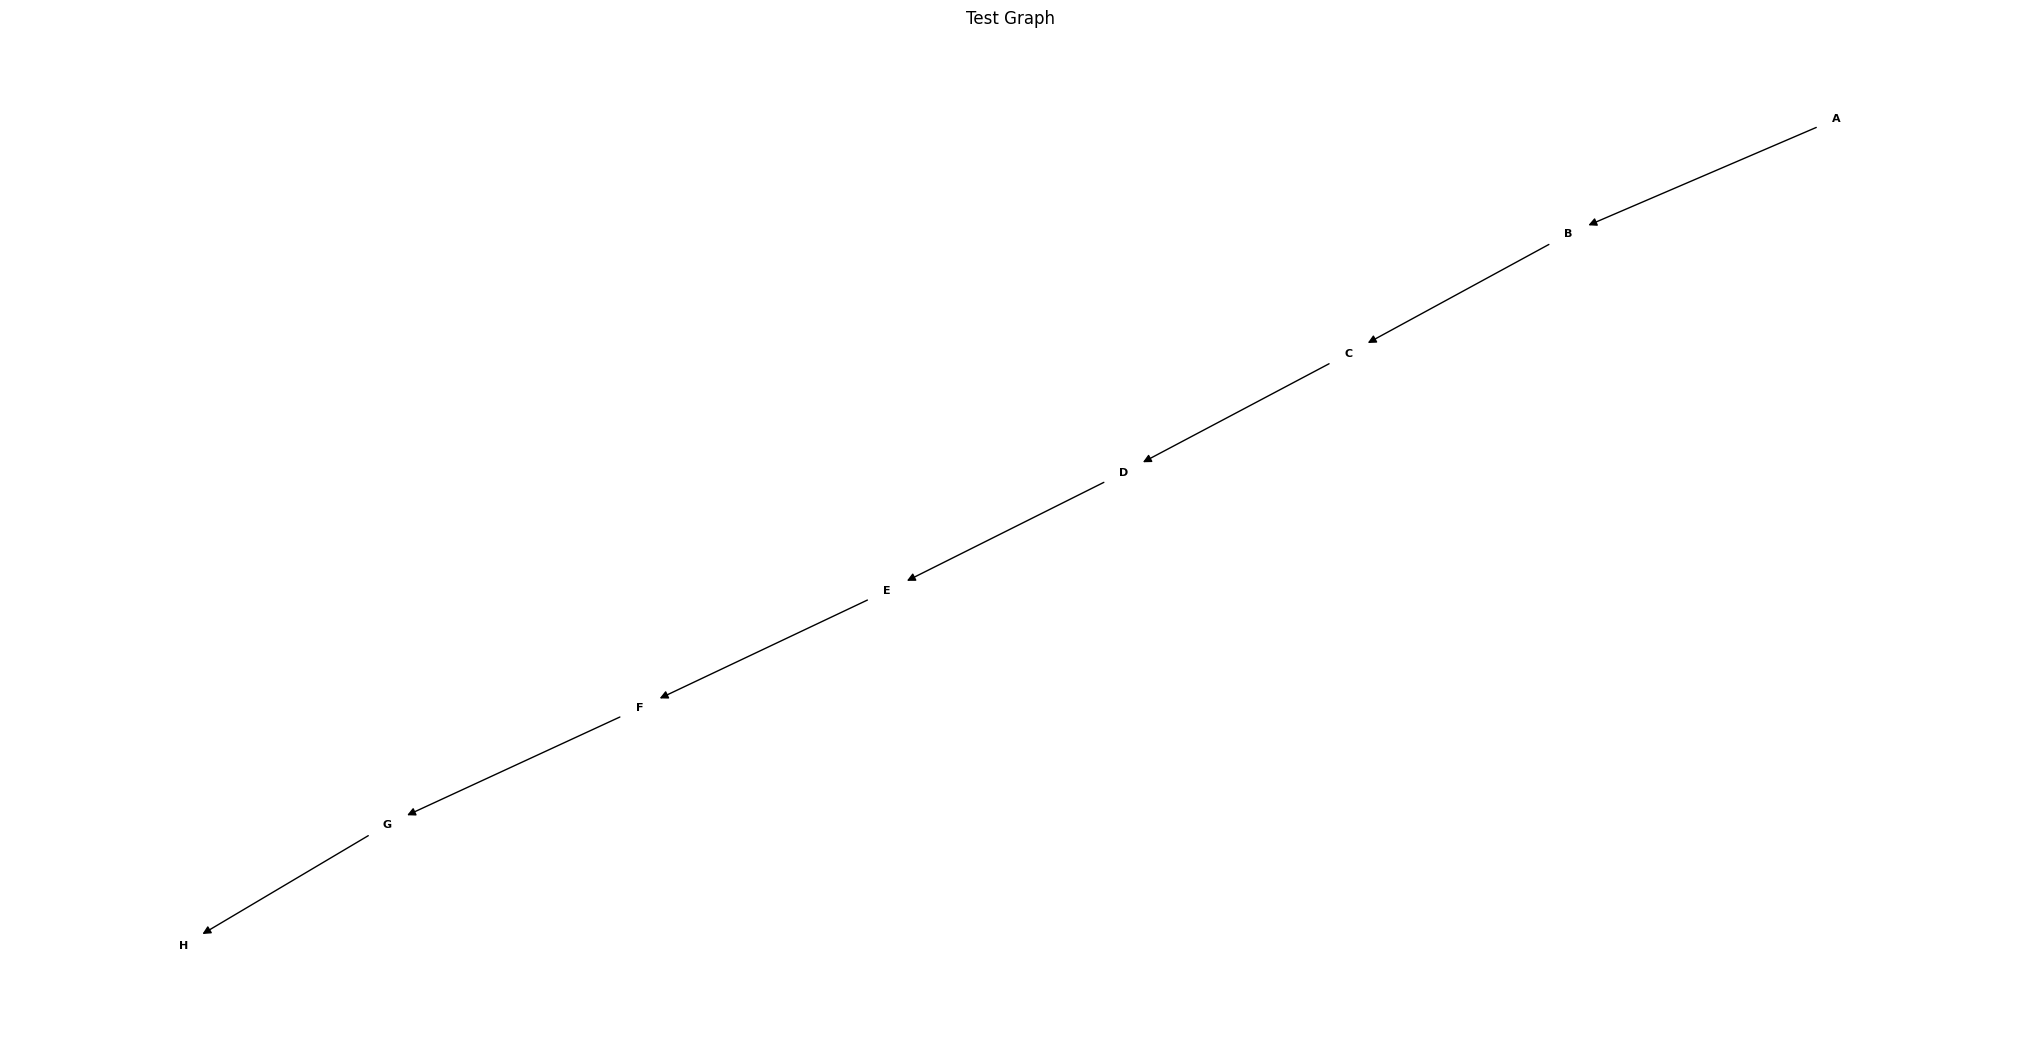

In [16]:
# Create a directed graph
exampleG = nx.DiGraph()
exampleG.add_edges_from([

    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'G'),
    ('G', 'H')


])

draw_graph(exampleG, "kamada_kawai", "Test Graph")



Processing root: H
Direct children of root H: ['G']
Current node: F, Children: ['E']
Current node: E, Children: ['D']
Current node: D, Children: ['C']
Current node: C, Children: ['B']
Current node: B, Children: ['A']
Current node: A, Children: []
Nodes to keep in branch: ['H', 'E', 'B', 'A']
Node E connected to H
Node B connected to E


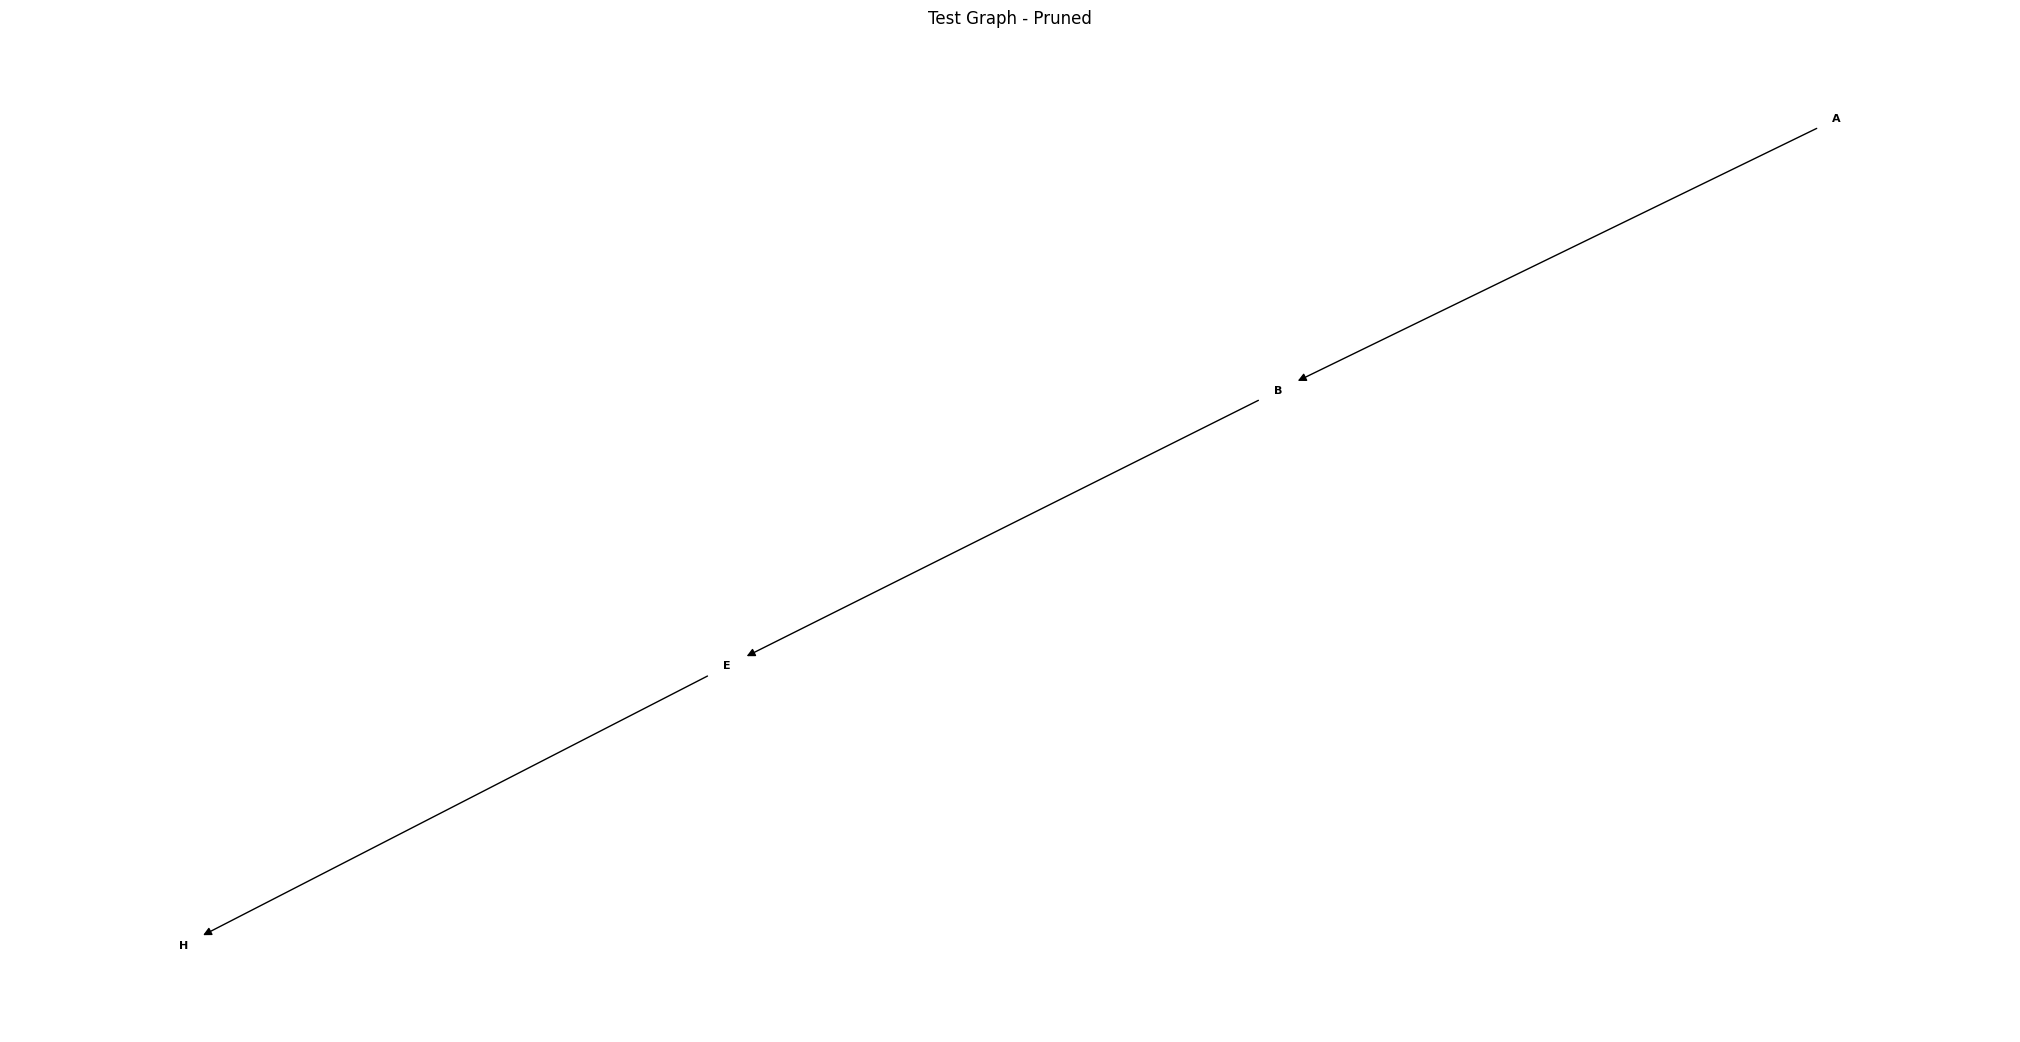

In [17]:
pruned_exampleG = exampleG.copy()
pruned_exampleG = linear_branch_collapser_pruner_remove_less(pruned_exampleG, 3)
draw_graph(pruned_exampleG, "kamada_kawai", "Test Graph - Pruned")


Processing root: H
Direct children of root H: ['G']
Current node: F, Children: ['E']
Current node: E, Children: ['D']
Current node: D, Children: ['C']
Current node: C, Children: ['B']
Current node: B, Children: ['A']
Current node: A, Children: []


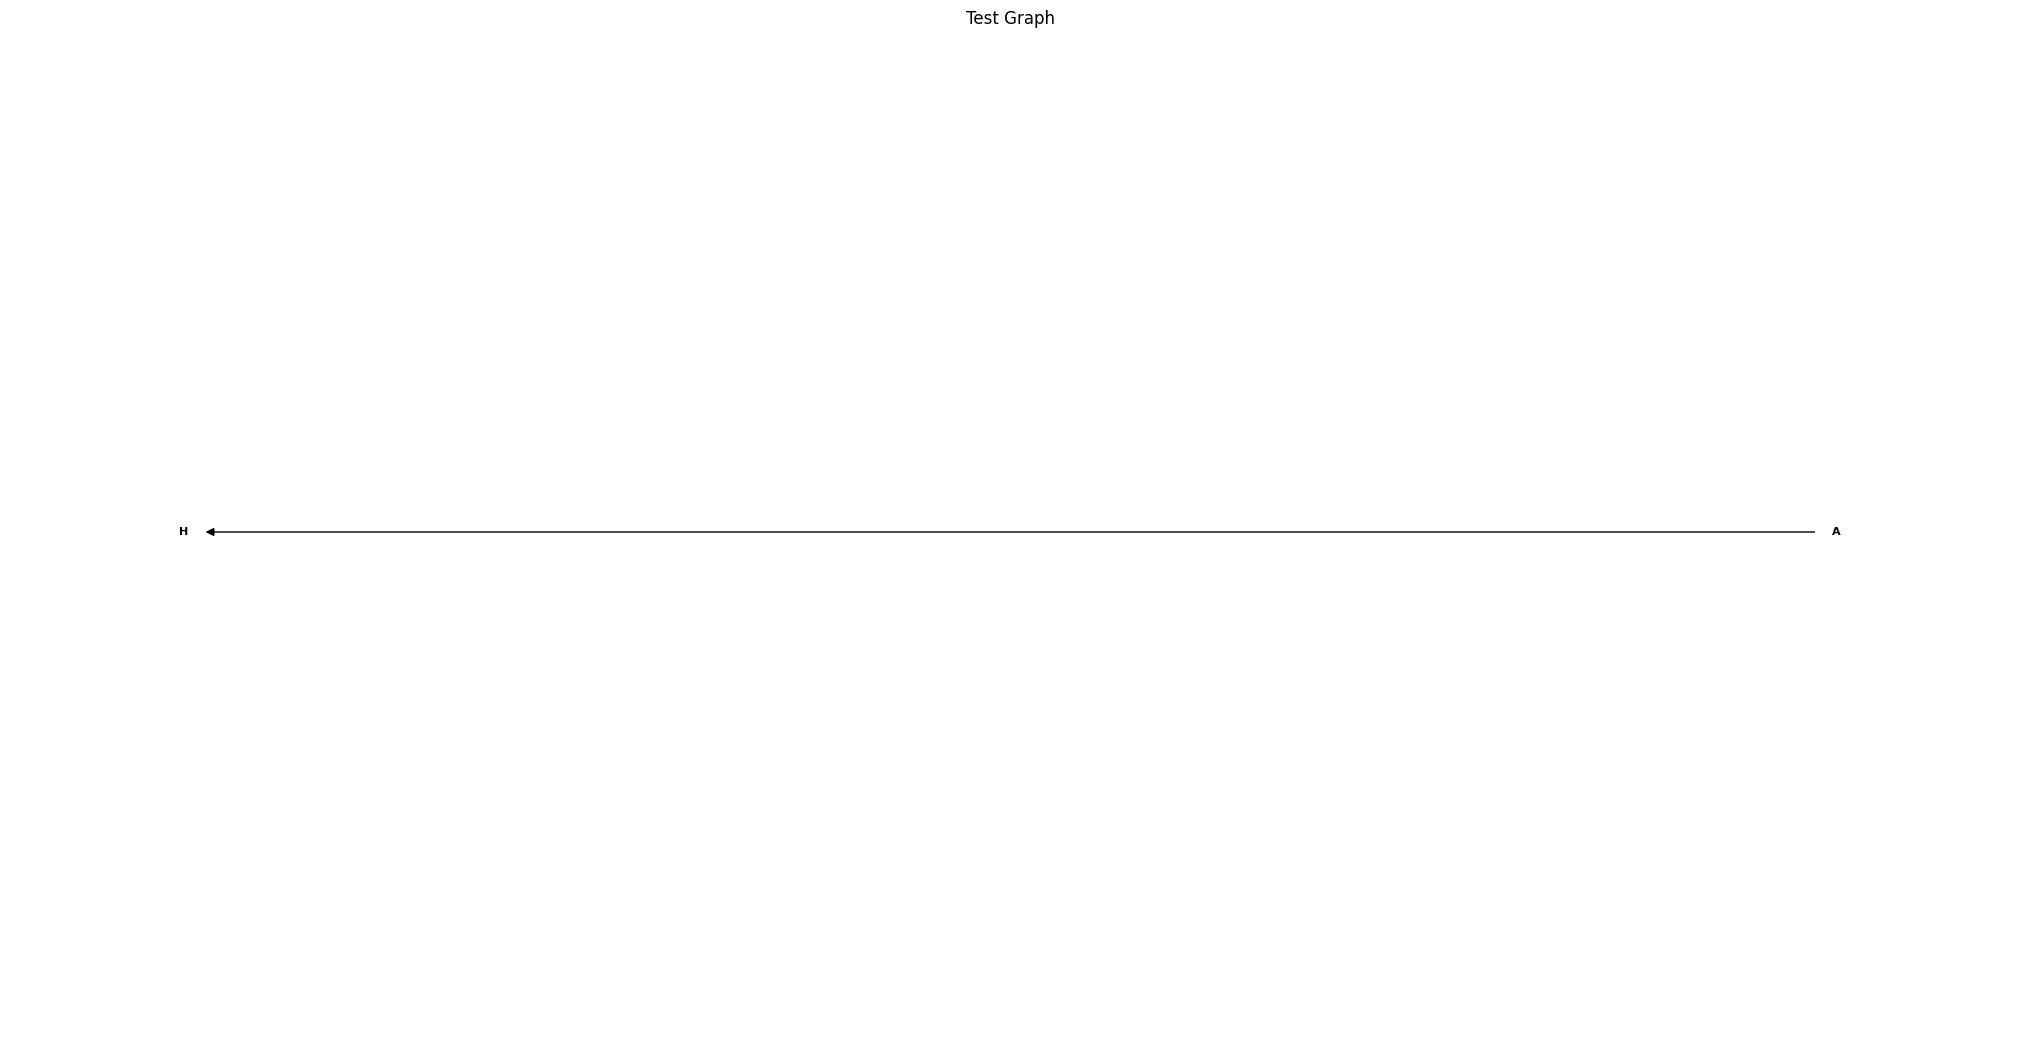

In [18]:
pruned_exampleG2 = exampleG.copy()
pruned_exampleG2 = linear_branch_collapser_pruner(pruned_exampleG2)
draw_graph(pruned_exampleG2, "kamada_kawai", "Test Graph")


In [19]:
# OBS: Not relevant yet at least

""" ZeroDegreePruner:
This pruner removes vertices that have zero degree (considering incoming and outgoing edges).
This type of vertices appear after some of the pruners are applied, leaving islands.
"""

def zero_degree_pruner(G):
    to_remove = []
    removed = []

    for node in G.nodes():
        if G.degree(node) == 0:
            to_remove.append(node)

    for node in to_remove:
        G.remove_node(node)
        removed.append(node)

    return G, removed

# ---- Usage ----
# To be ran after previous cell, otherwise the graph is not defined correctly.
pruned_G_3 = pruned_G_2.copy()

pruned_G_3, removed_nodes = zero_degree_pruner(pruned_G_3)
print(f"Removed nodes with zero degree: {removed_nodes}")

graphing_layout = "kamada_kawai" # options: "default", "kamada_kawai", "spectral", "layer_based"
draw_graph(pruned_G_3, graphing_layout, "Ontology graph after zero degree pruning")

NameError: name 'pruned_G_2' is not defined

Tried to get the names...

In [ ]:
# Seems to work well

import xml.etree.ElementTree as ET


def get_name(chebi_ontology, iri):

    tree = ET.parse("data/filtered_chebi_no_leaves_with_smiles_no_deprecated_unknown.owl")
    root = tree.getroot()

    ns = {
        'owl': 'http://www.w3.org/2002/07/owl#',
        'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
        'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'
    }
    
    # Find all OWL classes
    for cls in root.findall('owl:Class', ns):
        about = cls.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about')
        if about == iri:
            print(f"Found class for IRI: {iri}")
            # Find rdfs:label element
            label_elem = cls.find('rdfs:label', ns)
            if label_elem is not None:
                return label_elem.text.strip()

    return None  # if not found



# Example usage:

# iri = "http://purl.obolibrary.org/obo/CHEBI_27732" # Caffeine. Can only be found in full chebi.owl
# iri = "http://purl.obolibrary.org/obo/CHEBI_17234" # Glucose. Can be found in both files. Not a leaf class? Eg. D-Glucose is a sublass
# iri = "http://purl.obolibrary.org/obo/CHEBI_15377" # Water. Can be found in both files.
# iri = "http://purl.obolibrary.org/obo/CHEBI_32140" # Sodium caffeine benzoate. Can only be found in full chebi.owl
# iri = "http://purl.obolibrary.org/obo/CHEBI_15693" # Aldose # Can be found in both files.
# iri = "http://purl.obolibrary.org/obo/CHEBI_15693" # D-Glucose # Can be found in both files. # Has sublass royal jelly
# iri = "http://purl.obolibrary.org/obo/CHEBI_78665" # Royal jelly. 
iri = "http://purl.obolibrary.org/obo/CHEBI_23367" # Molecular entity. Found in unknown but not structural


name = get_name("data/chebi.owl", iri)
print(name)

name = get_name("data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural_new.owl", iri)
print(name)



Found class for IRI: http://purl.obolibrary.org/obo/CHEBI_23367
molecular entity
Found class for IRI: http://purl.obolibrary.org/obo/CHEBI_23367
molecular entity


In [ ]:
def get_label_from_iri(ontology, class_iri):
    """Extract the preferred name (label or synonym) from a CHEBI class IRI."""
    axioms = ontology.get_axioms_for_iri(class_iri)
    for axiom in axioms:
        comp = axiom.component
        if type(comp).__name__ == "AnnotationAssertion":
            ann = comp.ann
            if hasattr(ann, "ap"):
                prop_str = str(ann.ap)
                # Check for name or synonym fields
                if any(key in prop_str.lower() for key in ["label", "hasname", "hassynonym", "exactsynonym"]):
                    # Different pyhornedowl versions use .literal or .v for the value
                    if hasattr(ann, "v"):
                        return str(ann.v)
                    elif hasattr(ann, "literal"):
                        return str(ann.literal)
                    elif hasattr(ann, "value"):
                        return str(ann.value)
    return None



id = "http://purl.obolibrary.org/obo/CHEBI_17234"
ontology_file = "data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl"
ontology = load_ontology(ontology_file)

label = get_label_from_iri(ontology, id)
if label:
    print(f"Label for {id}: {label}")
else:
    print(f"No label found for {id}")


Loading ontology...
Loaded ontology from data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl with 14940 classes and 225551 axioms.
No label found for http://purl.obolibrary.org/obo/CHEBI_17234


In [ ]:
import xml.etree.ElementTree as ET

def get_label_from_iri(ontology_file, class_iri):
    """
    Extracts names and synonyms for a class IRI from an OWL file.
    Returns a list of tuples: (name_text, source_type).
    """
    tree = ET.parse(ontology_file)
    root = tree.getroot()

    ns = {
        'owl': 'http://www.w3.org/2002/07/owl#',
        'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    }

    results = []

    # --- Case 1: Direct name annotations under <owl:Class> ---
    for cls in root.findall(f".//owl:Class[@rdf:about='{class_iri}']", ns):
        for child in cls:
            tag = child.tag.split('}')[-1].lower()
            if child.text:
                if "label" in tag:
                    results.append((child.text.strip(), "rdfs:label")) #check
                elif "hasname" in tag:
                    results.append((child.text.strip(), "hasName"))
                elif "synonym" in tag:
                    results.append((child.text.strip(), "synonym"))
                elif "alternative" in tag:
                    results.append((child.text.strip(), "alternative ID or name"))

    # --- Case 2: Nested <owl:Axiom> blocks (annotatedTarget etc.) ---
    for axiom in root.findall("owl:Axiom", ns):
        src = axiom.find("owl:annotatedSource", ns)
        tgt = axiom.find("owl:annotatedTarget", ns)
        prop = axiom.find("owl:annotatedProperty", ns)
        if src is not None and src.attrib.get(f"{{{ns['rdf']}}}resource") == class_iri:
            if prop is not None:
                prop_iri = prop.attrib.get(f"{{{ns['rdf']}}}resource", "").lower()
                if tgt is not None and tgt.text:
                    if "hasrelatedsynonym" in prop_iri:
                        results.append((tgt.text.strip(), "related synonym"))
                    elif "hasexactsynonym" in prop_iri:
                        results.append((tgt.text.strip(), "exact synonym"))
                    elif "hasnarrow" in prop_iri:
                        results.append((tgt.text.strip(), "narrow synonym"))
                    elif "hasbroad" in prop_iri:
                        results.append((tgt.text.strip(), "broad synonym"))
                    elif "hasname" in prop_iri or "label" in prop_iri:
                        results.append((tgt.text.strip(), "label/name"))
                    else:
                        results.append((tgt.text.strip(), f"other annotation: {prop_iri}"))

    return results


In [ ]:
ontology_file = "data/filtered_chebi_no_leaves_with_smiles_no_deprecated_structural.owl"
class_iri = "http://purl.obolibrary.org/obo/CHEBI_38137"

names = get_label_from_iri(ontology_file, class_iri)
print(f"Labels/synonyms for {class_iri}:")
for n in names:
    print(" -", n)


Labels/synonyms for http://purl.obolibrary.org/obo/CHEBI_38137:
 - ('cas:4780-79-4', 'other annotation: http://www.geneontology.org/formats/oboinowl#hasdbxref')
 - ('kegg.compound:C14089', 'other annotation: http://www.geneontology.org/formats/oboinowl#hasdbxref')
 - ('pubmed:5476720', 'other annotation: http://www.geneontology.org/formats/oboinowl#hasdbxref')
 - ('reaxys:2042532', 'other annotation: http://www.geneontology.org/formats/oboinowl#hasdbxref')
 - ('umbbd.compound:c0720', 'other annotation: http://www.geneontology.org/formats/oboinowl#hasdbxref')
 - ('(naphthalen-1-yl)methanol', 'exact synonym')
 - ('1-naphthylmethanol', 'exact synonym')
 - ('(1-naphthyl)methanol', 'related synonym')
 - ('(naphthalen-1-yl)methanol', 'related synonym')
 - ('1-Hydroxymethylnaphthalene', 'related synonym')
 - ('1-Naphthalenemethanol', 'related synonym')
 - ('1-menaphthyl alcohol', 'related synonym')
 - ('1-naphthylmethanol', 'related synonym')
 - ('1-naphthylmethyl alcohol', 'related synonym')